Mike and Spencer

### Beyond the Emergency Department: Predictive Analytics for 6-Month Patient Admission in Harmony Healthcare

### Problem Statement

Our goal is to build a predictive model that identifies whether a patient will experience at least one ED admission within the next six months. Based on instructor feedback, we removed columns directly tied to emergency department data, forcing the model to learn broader risk signals rather than simply reproducing ED activity. This notebook documents data cleaning, exploratory visualization, and an initial predictive model using forward feature selection with logistic regression.

In [1]:
# from google.colab import drive
import pandas as pd
# drive.mount('/content/drive')
# Then, update the path in pd.read_excel, for example:
# df = pd.read_excel('/content/drive/MyDrive/Data Science CSC 108/HarmonyHealthcareOneWeek_9_2025.xlsx')

df = pd.read_excel('HarmonyHealthcareOneWeek_9_2025.xlsx')

# We want to keep the 'ED Episode Admit Last-6-Mths' column and remove all other columns with ED in the name
ed_columns = [col for col in df.columns if 'ED' in col and col != 'ED Episode Admit Last-6-Mths']
df = df.drop(columns=ed_columns)

# Assuming NaN in 'ED Episode Admit Last-6-Mths' means no admission, fill with 0 early
target = 'ED Episode Admit Last-6-Mths'
df[target] = df[target].fillna(0)

# Now we can remove any columns that are just empty to shrink the data further
df = df.dropna(axis=1, how='all')
df.head()

,Age,EHR Sex,ED Episode Admit Last-6-Mths,Most Recent Encounter Type,UDS Qualifying Encounter Count,UDS Homelessness Status,IP Episode Admit Date,IP Episode Admit Location,IP Episode Admit Readmit,IP Episode Admit Past-6-Mths,IP Episode DC Dispo,IP Episode DC Date,Pregnancy Est Delivery,Bacterial Infection Dx Date,Bacterial Infection Dx Code,Care Plan Date,Developmental Screening Date,Developmental Screening Code,Urine Microalbumin Date,Urine Microalbumin Code,Urine Microalbumin Result,COVID-19 Immunization Booster Dose Date,COVID-19 Immunization Booster Dose Code,COVID-19 Immunization Booster Dose Manufacturer,Tobacco Cessation Counseling Date,Tobacco Cessation Counseling Type,DTaP Imm 1st,MMR Imm 1st,Active Medications,ACE ARB Start Date,ACE ARB Stop Date,ACE ARB Med Name,Pregnant Patient High Risk Dx Code,Acute Respiratory Disease Dx Date,Acute Respiratory Disease Dx Code,Acute Upper Respiratory Infection Date,Acute Upper Respiratory Infection Code,ADHD Dx Date,ADHD Dx Code,ADHD Medication Start Date,...,Statin Med Start Date,Statin Med RxNorm,Statin Med Name,Stress Date,Stress Response,Stress Trigger,Stress ICD10-Date,Stress ICD10-Code,Stress Dx Date,Stress Dx Code,Substance Use Disorder Dx Date,Substance Use Disorder Dx Code,Suicidality Dx Date,Suicidality Dx Name,Positive TB Result Date,Positive TB Test Result,Nicotine Replacement Start Date,Nicotine Replacement RxNorm,Nicotine Replacement Stop Date,Nicotine Replacement Med Name,Transportation Trigger,Transportation Med-Date,Transportation Med-Response,Transportation NonMed-Date,Transportation NonMed-Reponse,Transportation ICD10-Insecurity-Date,Transportation ICD10-Insecurity-Code,UDS SDOH Triggers,UDS SDOH Tally,Uninsured,Urine Creatinine Date,Urine Creatinine Code,Urine Creatinine Result,Varicella Titer Date,Varicella Titer Code,Varicella Titer Result,Violence Screening Date,Violence Screening Type,Vision Screening Date,Vision Screening Code
0,26,male,0.0,TeleBHTher,21.0,Not Homeless,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaT,NaT,13,NaT,NaT,NaN,NaN,NaT,NaN,NaT,NaN,2016-08-17,F90.1,NaT,...,NaT,NaN,NaN,2/10/2025 12:00:00 AM,Not at all,N,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,2025-02-10,Domestic Violence PRAPARE,2024-11-08,99173
1,14,female,0.0,Nutrition,4.0,Not Homeless,NaT,NaN,NaN,NaN,NaN,NaT,NaT,2025-09-08,J06.9,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2011-11-10,2014-10-24,11,NaT,NaT,NaN,NaN,NaT,NaN,2025-09-08,J06.9,NaT,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2025-01-02,99173
2,11,male,0.0,F/U,5.0,Not Homeless,NaT,NaN,NaN,NaN,NaN,NaT,NaT,2020-02-03,J06.9,NaT,2017-01-11,SWYC 24 Months,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2014-11-03,2015-10-06,23,NaT,NaT,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2024-11-09,99173
3,49,male,0.0,BH Therapy,48.0,Not Homeless,NaT,NaN,NaN,NaN,NaN,NaT,NaT,2017-10-10,A53.0,2025-05-13,NaT,NaN,NaT,NaN,NaN,2021-12-07,207.0,Moderna,NaT,NaN,NaT,NaT,23,2025-09-18,NaT,Losartan Potassium,NaN,NaT,NaN,2025-07-16,J06.9,NaT,NaN,NaT,...,2025-06-02,617311.0,Atorvastatin Calcium,8/26/2025 12:00:00 AM,Not at all,N,NaN,NaN,2025-03-07,F43.21,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,N,8/26/2025 12:00:00 AM,N,8/26/2025 12:00:00 AM,N,NaN,NaN,FINANCIAL STRAIN FOOD,2.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN,2025-08-26,Domestic Violence PRAPARE,2024-09-25,99173
4,39,female,0.0,Telemed,4.0,Not Homeless,NaT,NaN,NaN,NaN,NaN,NaT,2023-03-17,NaT,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaT,NaT,4,NaT,NaT,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaN,7/26/2025 12:00:00 AM,A little bit,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,N,7/26

In [2]:
target = 'ED Episode Admit Last-6-Mths' # Store our target var so we can use it later

# Check target distribution
print(df[target].value_counts())
print(df[target].value_counts(normalize=True) * 100)

# Check missing percentages
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

ED Episode Admit Last-6-Mths
0.0     2442
1.0      170
2.0       39
3.0       10
4.0        4
5.0        4
6.0        1
34.0       1
7.0        1
Name: count, dtype: int64
ED Episode Admit Last-6-Mths
0.0     91.392216
1.0      6.362275
2.0      1.459581
3.0      0.374251
4.0      0.149701
5.0      0.149701
6.0      0.037425
34.0     0.037425
7.0      0.037425
Name: proportion, dtype: float64
Material Security Food-Insecurity-ICD10-Date    99.962575
Opioid Dependence Dx Name                       99.962575
Transportation ICD10-Insecurity-Code            99.962575
Transportation ICD10-Insecurity-Date            99.962575
Cerebral Palsy Date                             99.962575
                                                  ...    
SDOH Triggers                                    0.898204
Patient Appointment No-Show Rate %               0.149701
Patient Appointment No-Show Count                0.149701
Patient Medicaid Risk Total Risk                 0.074850
Patient Medicaid Risk Ri

In [3]:
# Drop columns with >70% missing, except target
columns_to_drop = [c for c in df.columns if c != target and df[c].isna().mean() * 100 > 70]
print("Number of columns to drop:", len(columns_to_drop))
df = df.drop(columns=columns_to_drop)
df.head()

Number of columns to drop: 417


,Age,EHR Sex,ED Episode Admit Last-6-Mths,Most Recent Encounter Type,UDS Qualifying Encounter Count,UDS Homelessness Status,Active Medications,Alcohol Assessment Date,Alcohol Assessment Code,Alcohol Assessment Result,Anti-HTN Med Date,Anti-HTN Med Name,Patient Appointment No-Show Count,Patient Appointment No-Show Rate %,AST Date,AST Result,Blood Pressure Vitals Date,Blood Pressure Value,Blood Pressure Systolic,Blood Pressure Diastolic,Most Recent BMI Date,Most Recent BMI Value,Patient Medicaid Risk Total Risk,Patient Medicaid Risk Risk Gap,Chlamydia Screen Date,Chlamydia Screen Code,Chlamydia Screen Result,Cholesterol Date,Cholesterol Code,Cholesterol Result,Colorectal Cancer Screening Status Date,Colorectal Cancer Screening Status Message,Colorectal Cancer Screening Status Next Due,Dental Visit Date,Depression Screening Date,Depression Screening Type,Depression Screening Result,Depression Screening Count Past Yr,Domestic Violence Date,Domestic Violence Reponse,...,Primary Care Encounter Date,Primary Care Encounter Provider,Primary Care Encounter Location,Primary Care Encounter Count,Insurance Date,Insurance Financial Class,Insurance Primary Payer,Public Housing,Safety Date,Safety Response,SDOH Assessment Status,SDOH Assessment Completed,SDOH Assessment Count,Social Needs Assessment Date,Social Needs Assessment Screening Format,SDOH Triggers,SDOH Tally,Serum Creatinine Date,Serum Creatinine Test,Serum Creatinine Result,Sexual Orientation,Sexually Active Date,Sexually Active Code,Sexually Active Detail,Smoking Status Date,Smoking Status Detail,Statin Med Start Date,Statin Med RxNorm,Statin Med Name,Stress Date,Stress Response,Transportation Trigger,Transportation NonMed-Date,Transportation NonMed-Reponse,UDS SDOH Triggers,UDS SDOH Tally,Violence Screening Date,Violence Screening Type,Vision Screening Date,Vision Screening Code
0,26,male,0.0,TeleBHTher,21.0,Not Homeless,13,2024-12-06,AUDIT-C,0.0,NaT,NaN,17.0,19.54,2024-11-08,17.0,2024-11-08,120/82,120.0,82.0,2024-11-08 11:45:00,34.55,0.425,0.000,2024-10-01,42931-6,Negative,2024-11-08,2093-3,177.0,NaT,NaN,NaN,NaT,2025-08-07,PHQ-9 Depression Screen,Positive,4.0,2/10/2025 12:00:00 AM,N,...,2024-12-06 10:00:00,"Gay, Tulie",Roosevelt Harmony Health Care Long Island,10.0,9/30/2025 11:59:59 PM,Dual Eligible Medicare and Medicaid,Medicare NY Part A Upstate,False,2/10/2025 12:00:00 AM,Y,Core IN Progress,"Housing status or Housing situation, Food, Uti...",4,2023-06-27,DNU-PRPARE,FPL<200% EMPLOYMENT,2,2024-11-08,2160-0,0.85,Straight (not lesbian or gay),2024-11-14,Sexually Active,"Sexually Active = ""Y""",2024-12-06,N,NaT,NaN,NaN,2/10/2025 12:00:00 AM,Not at all,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,2025-02-10,Domestic Violence PRAPARE,2024-11-08,99173
1,14,female,0.0,Nutrition,4.0,Not Homeless,11,2025-09-17,AUDIT-C,0.0,NaT,NaN,0.0,0.00,2025-01-02,23.0,2025-09-08,120/78,120.0,78.0,2025-09-17 14:00:00,35.97,-0.025,0.000,2025-01-02,42931-6,Negative,2025-01-02,2093-3,153.0,NaT,NaN,NaN,NaT,2025-01-02,PHQ-2 Depression Screen,Negative,1.0,NaN,NaN,...,2025-09-08 10:00:00,"Edwards, Alexandria",Westbury Harmony Health Care Long Island,10.0,9/30/2025 11:59:59 PM,Medicaid,HealthFirst MCD,False,NaN,NaN,Core IN Progress,Housing status or Housing situation,1,2025-09-08,Social Barriers to Care,FPL<200% HISP/LAT LANGUAGE,3,NaT,NaN,NaN,Straight (not lesbian or gay),NaT,NaN,NaN,2025-09-17,N,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,NaT,NaN,2025-01-02,99173
2,11,male,0.0,F/U,5.0,Not Homeless,23,NaT,NaN,NaN,NaT,NaN,2.0,16.67,NaT,NaN,2025-09-17,101/56,101.0,56.0,2025-09-17 11:15:00,27.92,-0.025,0.000,NaT,NaN,NaN,2024-11-14,2093-3,203.0,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,2025-09-17 11:15:00,"Fortin, Deborah",Roosevelt Harmony Health Care Long Island,9.0,9/30/2025 11:59:59 PM,Medicaid,Anthem BCBS Healthplus MCD,False,NaN,NaN,Core IN Progress,Housing status or Housing situation,1,2025-09-10,DNU-PRPARE,FPL<200% HISP/LAT,2,NaT,NaN,NaN,Straight (not lesbian or gay),NaT,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,

In [4]:
# Impute missing values + encode categoricals

from sklearn.impute import SimpleImputer

target_col = 'ED Episode Admit Last-6-Mths' # Define target here too for consistency

# Separate numerical + categorical
numeric_cols = df.select_dtypes(include='number').columns.tolist()
# Exclude the target column from numeric imputation
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute numerics with median
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute categoricals with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Columns: 7049 entries, Age to Vision Screening Code_Z01.01
dtypes: bool(6970), datetime64[ns](40), float64(39)
memory usage: 19.4 MB


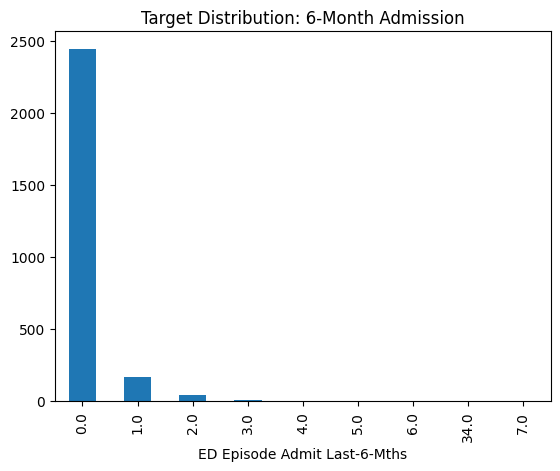

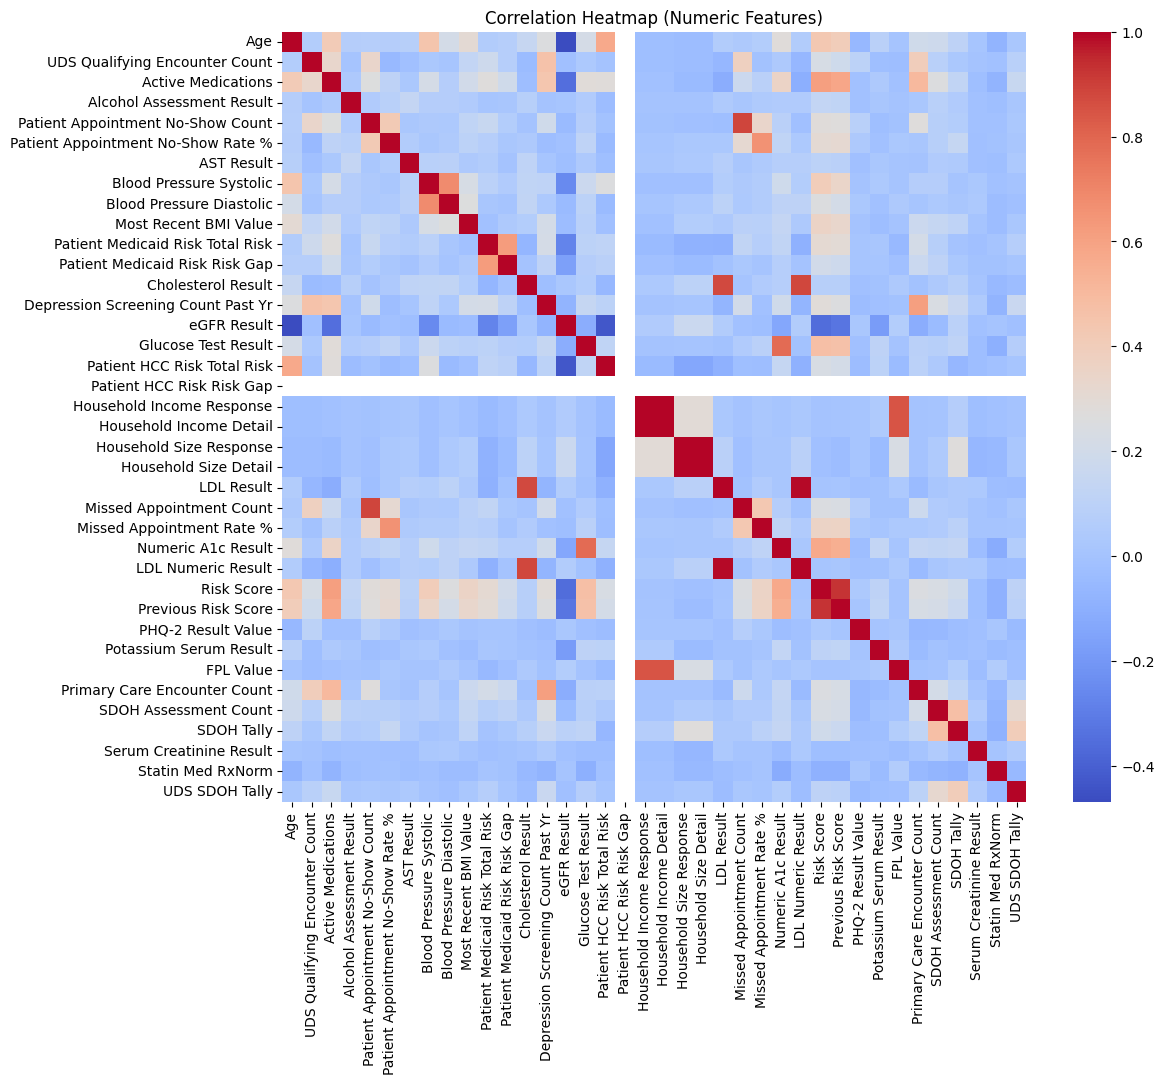

In [5]:
# Visualizations!

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Target distribution
df[target].value_counts().plot(kind='bar')
plt.title("Target Distribution: 6-Month Admission")
plt.show()

# 2. Histogram of top numeric features
# df[numeric_cols].hist(figsize=(12,10))
# plt.tight_layout()
# plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [6]:
# Convert target to binary (admitted = 1 if >0)
y = (df[target] > 0).astype(int)
X = df.drop(columns=[target])

In [7]:
# Clean and prepare data

# Make a copy of the dataframe to avoid modifying the original `df` from the previous cell.
df_processed = df.copy()

# Target column name
target_col_name = "ED Episode Admit Last-6-Mths"

# Isolate the target variable BEFORE any potentially destructive transformations.
# Apply fillna(0) and >0 to ensure binary classification, and then convert to int.
y = (df_processed[target_col_name].fillna(0) > 0).astype(int)

# Drop the target column from the feature set X
X = df_processed.drop(columns=[target_col_name])

# Identify columns that are actual datetime objects in X.
# These are the columns from `df.info()` with dtypes `datetime64[ns]` from the previous step.
datetime_cols_in_X = X.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Convert identified datetime columns in X to numeric days since epoch.
# This avoids incorrectly converting other numeric columns.
for col in datetime_cols_in_X:
    X[col] = (X[col] - pd.Timestamp("1970-01-01")).dt.days

# Replace remaining missing numerical values in X with column medians.
# This imputation step is for the features (X) after date conversion.
X = X.fillna(X.median(numeric_only=True))

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Logistic Regression + evaluation function
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def evaluate(feature_list):
    idxs = [X.columns.get_loc(f) for f in feature_list]

    model = LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    )

    model.fit(X_train_scaled[:, idxs], y_train)

    preds = model.predict_proba(X_test_scaled[:, idxs])[:, 1]

    return roc_auc_score(y_test, preds)

In [9]:
# Greedy forward feature selection

# Initialize lists: 'remaining' holds features not yet selected, 'selected' holds chosen features,
# and 'scores' stores the AUC for the selected feature set at each step.
remaining = list(X.columns)
selected = []
scores = []

# Perform 10 steps of forward feature selection.
# In each step, we find the single best feature to add to our 'selected' set.
for step in range(10):
    best_feature = None
    best_auc = -1 # Initialize with a low AUC score to ensure the first valid AUC is higher

    # Iterate through all features not yet selected to find the one that maximizes AUC when added.
    for feat in remaining:
        # Create a temporary list of features that includes currently selected features plus one 'candidate' feature.
        try_features = selected + [feat]
        # Evaluate the performance (AUC) of the model using this candidate set of features.
        auc = evaluate(try_features)

        # If this candidate set yields a better AUC than the current best, update best_auc and best_feature.
        if auc > best_auc:
            best_auc = auc
            best_feature = feat

    # Add the best performing feature from this step to the 'selected' list.
    selected.append(best_feature)
    # Record the AUC achieved with this new set of selected features.
    scores.append(best_auc)
    # Remove the selected feature from the 'remaining' list so it's not considered again.
    remaining.remove(best_feature)

    # Print the result for the current step.
    # print(f"Step {step+1}: Selected {best_feature} — AUC {best_auc:.4f}")

# After all steps are complete, print the final list of top 10 selected features and their corresponding AUC scores.
print("\nTop 10 selected features:")
for i, (feat, auc) in enumerate(zip(selected, scores), 1):
    print(f"{i}. {feat} — AUC {auc:.4f}")


Top 10 selected features:
1. Depression Screening Count Past Yr — AUC 0.6041
2. Age — AUC 0.6427
3. Insurance Primary Payer_HealthFirst MCR — AUC 0.6774
4. Colorectal Cancer Screening Status Next Due_05/05/2028 — AUC 0.7006
5. Insurance Primary Payer_HealthFirst MCD — AUC 0.7161
6. eGFR Date — AUC 0.7434
7. SDOH Triggers_FPL<200% HISP/LAT  — AUC 0.7624
8. Sexually Active Detail_Pap Test — AUC 0.7767
9. Insurance Primary Payer_HealthFirst Essential Tier 3-4 — AUC 0.7881
10. SDOH Triggers_FPL<200% INSURANCE RACE  — AUC 0.7979


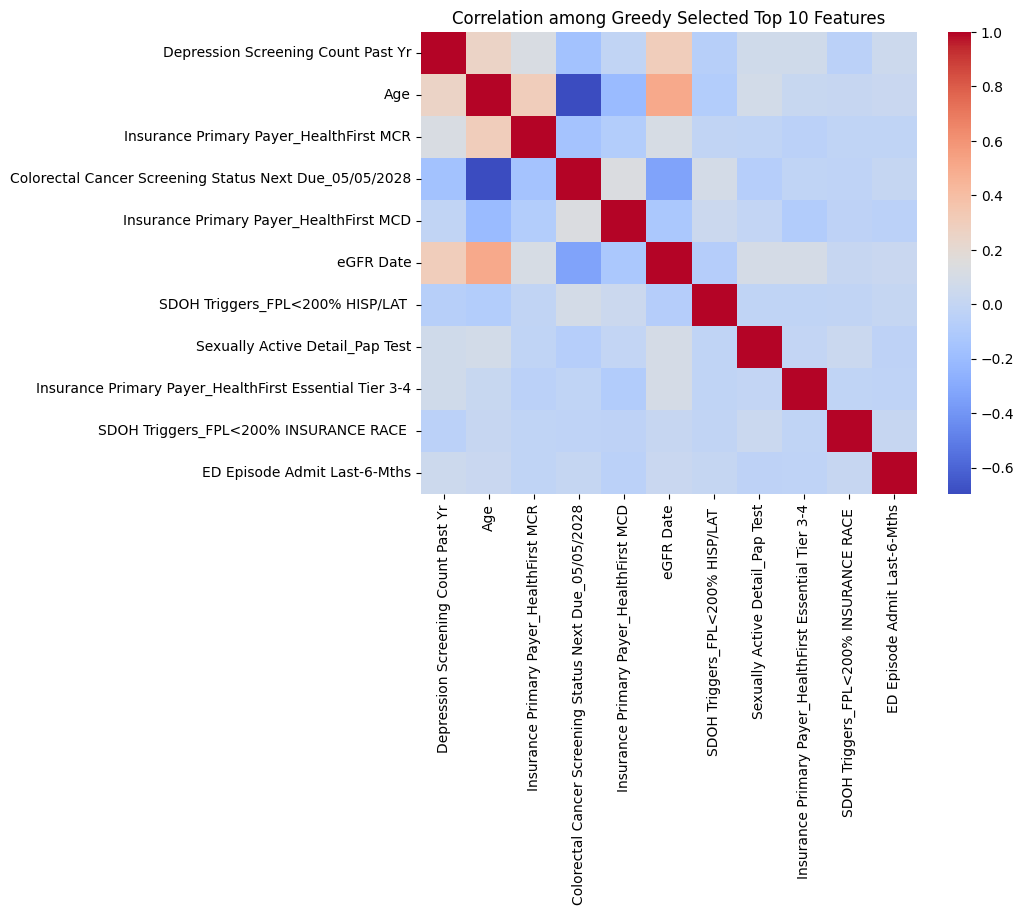

In [10]:
# Are the top 10 selected features correlated to each other?
selected_df = df[selected + [target]]
corr = selected_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation among Greedy Selected Top 10 Features")
plt.show()


In [11]:
# 5 fold Cross-Validation

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Use only the greedy-selected top 10 features
X_selected = X[selected]

# Build pipeline to avoid data leakage
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    ))
])

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline,
    X_selected,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("5-fold CV AUC scores:", cv_scores)
print("Mean CV AUC:", np.mean(cv_scores))
print("Std CV AUC:", np.std(cv_scores))


5-fold CV AUC scores: [0.68913933 0.64506091 0.62050071 0.66932466 0.68208749]
Mean CV AUC: 0.6612226192922849
Std CV AUC: 0.025297443168453084


In [ ]:

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold


def lasso_classification_comparison(X, y, greedy_selected_features, greedy_auc):
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Use LogisticRegressionCV with L1 penalty (Lasso for classification)
    # C is inverse of regularization strength (smaller C = more regularization)
    Cs = np.logspace(-4, 2, 20)  # Test range of regularization strengths
    
    # add verbose=1 to see progress
    lasso_logistic = LogisticRegressionCV(
        Cs=Cs,
        cv=5,
        penalty='l1',
        solver='liblinear',  # Required for L1 penalty
        max_iter=50000,
        class_weight='balanced',  # Handle class imbalance like your greedy method
        scoring='roc_auc',  # Use AUC like your greedy method
        random_state=42,
        n_jobs=-1
    )
    
    print("\nFitting L1-regularized Logistic Regression...")
    lasso_logistic.fit(X_scaled, y)
    
    print(f"Optimal C (inverse regularization): {lasso_logistic.C_[0]:.6f}")
    print(f"  (Smaller C = more regularization, like larger alpha in Lasso)")
    
    # Get coefficients
    coefficients = pd.DataFrame({
        'feature': X.columns,
        'coefficient': lasso_logistic.coef_[0]
    })
    
    # Select non-zero features
    selected_features = coefficients[coefficients['coefficient'] != 0].copy()
    selected_features = selected_features.sort_values(
        'coefficient', 
        key=abs, 
        ascending=False
    )
    
    print(f"\nNumber of features selected: {len(selected_features)}/{len(X.columns)}")
    print(f"Feature reduction: {(1 - len(selected_features)/len(X.columns))*100:.1f}%")
    
    print("\nTop 20 selected features and coefficients:")
    print(selected_features.head(20).to_string(index=False))
    
    if len(selected_features) > 20:
        print(f"\n... and {len(selected_features) - 20} more features")
    
    # Calculate performance metrics using CLASSIFICATION metrics
    y_pred_proba = lasso_logistic.predict_proba(X_scaled)[:, 1]
    y_pred = lasso_logistic.predict(X_scaled)
    
    train_auc = roc_auc_score(y, y_pred_proba)
    train_acc = accuracy_score(y, y_pred)
    
    print(f"\nTRAIN Performance:")
    print(f"  AUC: {train_auc:.4f}")
    print(f"  Accuracy: {train_acc:.4f}")
    
    # Cross-validation with proper classification scoring
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_auc_scores = cross_val_score(
        lasso_logistic, X_scaled, y, cv=cv, scoring='roc_auc'
    )
    cv_acc_scores = cross_val_score(
        lasso_logistic, X_scaled, y, cv=cv, scoring='accuracy'
    )
    
    print(f"\nCROSS-VALIDATION Performance (5-fold):")
    print(f"  AUC: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")
    print(f"  Accuracy: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
    
    # Comparison with Greedy Forward Selection
    print("\n" + "="*70)
    print("COMPARISON: L1 Logistic Regression vs Greedy Forward Selection")
    print("="*70)
    
    print(f"\nNumber of features:")
    print(f"  Greedy Forward Selection: {len(greedy_selected_features)}")
    print(f"  L1 Logistic (Lasso):      {len(selected_features)}")
    
    print(f"\nCross-Validation AUC:")
    print(f"  Greedy Forward Selection: {greedy_auc:.4f}")
    print(f"  L1 Logistic (Lasso):      {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")
    
    # Feature overlap analysis
    lasso_set = set(selected_features['feature'].tolist())
    greedy_set = set(greedy_selected_features)
    
    common = lasso_set & greedy_set
    only_lasso = lasso_set - greedy_set
    only_greedy = greedy_set - lasso_set
    
    print(f"\nFeature Overlap:")
    print(f"  Common features: {len(common)}/{len(greedy_set)}")
    if common:
        print(f"    {sorted(list(common)[:10])}")
        if len(common) > 10:
            print(f"    ... and {len(common) - 10} more")
    
    print(f"\n  Only in L1 Logistic: {len(only_lasso)}")
    if only_lasso and len(only_lasso) <= 10:
        print(f"    {sorted(list(only_lasso))}")
    elif only_lasso:
        print(f"    {sorted(list(only_lasso))[:10]}")
        print(f"    ... and {len(only_lasso) - 10} more")
    
    print(f"\n  Only in Greedy: {len(only_greedy)}")
    if only_greedy:
        print(f"    {sorted(list(only_greedy))}")
    
    return {
        'model': lasso_logistic,
        'scaler': scaler,
        'selected_features': selected_features,
        'feature_names': selected_features['feature'].tolist(),
        'train_auc': train_auc,
        'cv_auc_mean': cv_auc_scores.mean(),
        'cv_auc_std': cv_auc_scores.std(),
        'cv_auc_scores': cv_auc_scores,
        'optimal_C': lasso_logistic.C_[0]
    }


"""
# After the greedy forward selection completes you have:
# - selected: list of top 10 features from greedy
# - scores: list of AUC scores from greedy
# - X: your full feature matrix
# - y: your binary target
"""
greedy_best_auc = scores[-1]  # Last score is with all 10 features

lasso_results = lasso_classification_comparison(
    X=X,
    y=y,
    greedy_selected_features=selected,
    greedy_auc=greedy_best_auc
)

    


Fitting L1-regularized Logistic Regression...
Optimal C (inverse regularization): 0.297635
  (Smaller C = more regularization, like larger alpha in Lasso)

Number of features selected: 934/7048
Feature reduction: 86.7%

Top 20 selected features and coefficients:
                                               feature  coefficient
Colorectal Cancer Screening Status Next Due_05/05/2028     0.590377
                           Blood Pressure Value_120/80     0.403904
                        FPL Date_5/12/2025 12:00:00 AM     0.358494
                        FPL Date_3/27/2025 12:00:00 AM     0.316371
                            Blood Pressure Vitals Date     0.294742
                           Blood Pressure Value_120/90     0.281138
                           Blood Pressure Value_107/71     0.269044
              Insurance Primary Payer_Bluecard Program     0.265444
                        FPL Date_7/25/2025 12:00:00 AM     0.254953
          Housing Situation-Date_9/16/2025 12:00:00 AM  

### Discussion of Early Results and Moving Forward

* The greedy selection approach identified a ranked set of features contributing incremental predictive value.
* The AUC values supply an interpretable measure of classification.
* Further improvements planned include:
    1. Cross validate the model with testing data
    2. Plot the AUC for more than 10 features
    3. Check correlation of selected features to make sure we are not selecting highly correlated features
    4. Attempt to compare to Lasso if enough time

The project was a collaborative effort between Mike and Spencer with both of us working on the data cleaning step and Mike taking charge of the algorithm and Spencer doing the write up and github steps.


### Later Results and Finalizations (final Jupyter notebook)

After the initial notebook, we accomplished most of our planned further improvements. Spencer moved forward with implementing the lasso algorithm to compare to the previous team working on this dataset per professor feedback, and Mike implemented the 5-fold cross validation and added a heatmap to check if the top 10 selected features from the greedy algorithm are correlated to each other.
* Successful improvements we managed to do after the initial notebook:
    1. Cross validate the model with 5-fold CV
    2. Check correlation of selected features using heatmap
    3. Compare to Lasso algorithm

The project can be shared with future students.

Github link: https://github.com/99x5zbrvgj-droid/CSC108HHCFinal